  
# The analysis of Multilevel Monitoring of Activity and Sleep in Healthy people (MMASH) dataset

Dataset download link https://physionet.org/content/mmash/1.0.0/

> Multilevel Monitoring of Activity and Sleep in Healthy people (MMASH) dataset provides 24 hours of continuous beat-to-beat heart data, triaxial accelerometer data, sleep quality, physical activity and psychological characteristics (i.e., anxiety status, stress events and emotions) for 22 healthy participants. Moreover, saliva bio-markers (i.e.cortisol and melatonin) and activity log were also provided in this dataset. The MMASH dataset will enable researchers to test the correlations between physical activity, sleep quality, and psychological characteristics.


**Streams to explore:**  
- _Explore the relationship between individual characteristics (e.g. daily stress, anxiety status, daily activities) and observed sleep quality (e.g., melatonin, cortisol, sleep fragmentation index, sleep length)._
- Detect daily activities, moods, emotions using cardiovascular responses (e.g., heart rate and heart rate variability) and/or accelerometers data
- Heart rate variability (HRV) analysis
- Circadian state detection  
 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(123)
sns.set(font_scale=1.2)

from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from IPython.display import display


plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = None
pd.options.display.width=None

## Load data


**Data Description**  
MMASH dataset consists of seven files for each participant:

- user_info.csv - anthropocentric characteristics of the participant
- sleep.csv - information about sleep duration and sleep quality of the participant
- RR.csv - beat-to-beat interval data
- questionnaire.csv - scores for all the questionnaires
- Activity.csv - list of the activity categories throughout the day:  
    1. sleeping.
    2. laying down.
    3. sitting, e.g. studying, eating and driving.
    4. light movement, e.g. slow/medium walk, chores and work.
    5. medium, e.g. fast walk and bike.
    6. heavy, e.g. gym, running.
    7. eating.
    8. small screen usage, e.g. smartphone and computer.
    9. large screen usage, e.g. TV and cinema.
    10. caffeinated drink consumption, e.g. coffee or coke.
    11. smoking.
    12. alcohol assumption.
- Actigraph.csv - accelerometer and inclinometer data recorded throughout the day. Actigraphy is the process of monitoring gross motor skills (larger movement activities such as sitting, rolling, kneeling, crawling, walking, running, jumping, skipping and etc)
- saliva.csv - clock genes and hormones concentrations in the saliva before going to bed and after waking up. No data was provided for User_21 due to problem in the salivary samples that do not permit to analyse it.


Let's load all the data from files:

In [2]:
ROOT_PATH = 'data/MMASH'
folders = os.listdir(ROOT_PATH)
files = ['Actigraph.csv', 'Activity.csv', 'questionnaire.csv',  'RR.csv', 'saliva.csv', 'sleep.csv', 'user_info.csv']


In [3]:
sleep_data_static = {}
sleep_data_dynamic = {'actigraph': {}, 'activity': {}, 'rr': {}}

for folder in folders:
    for file in files:
        path_to_file = os.path.join(ROOT_PATH, folder, file)
        file_name = file.split('.')[0].lower()
        if os.path.exists(path_to_file):
            file_data = pd.read_csv(path_to_file, index_col=0)
            if file in ['Actigraph.csv', 'Activity.csv', 'RR.csv']:
                sleep_data_dynamic[file_name][folder] = file_data
            else:
                file_data.insert(0, 'User', folder)
                if file_name in sleep_data_static.keys():
                    sleep_data_static[file_name] = sleep_data_static[file_name].append(file_data, ignore_index=True)
                else:
                    sleep_data_static[file_name] = file_data
        else:
            print(f"File '{path_to_file}' doesn't exist.")

print(f"Total participants: {len(folders)}")

File 'data/MMASH/user_21/saliva.csv' doesn't exist.
Total participants: 22


In [4]:
sleep_data_static['questionnaire'].set_index('User', inplace=True)
sleep_data_static['saliva'].set_index(['User', 'SAMPLES'], inplace=True)
sleep_data_static['sleep'].set_index('User', inplace=True)
sleep_data_static['user_info'].set_index('User', inplace=True)


In [5]:
sleep_data_static['saliva'] = sleep_data_static['saliva'].unstack(level=1)
sleep_data_static['saliva'].columns = ['Cortisol_before', 'Cortisol_after', 'Melatonin_before', 'Melatonin_after']

Let's take a highlevel view on the datasets.

### Static data

#### 'saliva' dataset

In [9]:
print(f"Shape: {sleep_data_static['saliva'].shape}")
display(sleep_data_static['saliva'].head(5))
sleep_data_static['saliva'].describe()

Shape: (21, 4)


,Cortisol_before,Cortisol_after,Melatonin_before,Melatonin_after
User,,,,
user_1,0.034137,0.077939,1.738385e-08,6.747893e-09
user_10,0.037046,0.019659,8.669611e-09,2.573795e-09
user_11,0.040592,0.015572,2.038077e-09,9.653476e-09
user_12,0.155777,0.145431,3.542804e-09,8.639988e-09
user_13,0.012278,0.034191,1.902268e-09,2.295933e-09


,Cortisol_before,Cortisol_after,Melatonin_before,Melatonin_after
count,21.000000,21.000000,2.100000e+01,2.100000e+01
mean,0.028053,0.069860,8.330234e-09,6.964888e-09
std,0.030470,0.053220,6.707615e-09,6.392950e-09
min,0.012017,0.015572,1.629907e-09,0.000000e+00
25%,0.015166,0.041724,3.334482e-09,2.573795e-09
50%,0.020206,0.057075,5.714439e-09,5.730512e-09
75%,0.025968,0.081888,1.126009e-08,8.639988e-09
max,0.155777,0.261252,2.396239e-08,2.853905e-08


Lower cortisol and higher melatonin level before sleep should be indicators for a good sleep. This hypothesis can be used during EDA.
Note that there are only 21 (not 22) results/records.

Let's consider pairwise relationships:

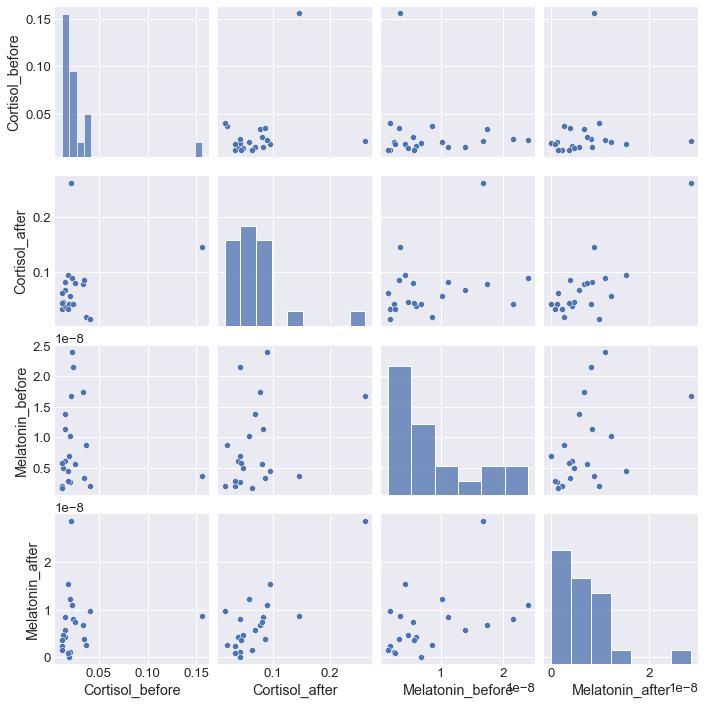

In [10]:
sns.pairplot(sleep_data_static['saliva']);

It seems that there's some relationship between Melatonin_after and Cortisol_after.

#### 'sleep' dataset

In [11]:
print(f"Shape: {sleep_data_static['sleep'].shape}")
display(sleep_data_static['sleep'].head(5))
sleep_data_static['sleep'].describe()

Shape: (22, 16)


,In Bed Date,In Bed Time,Out Bed Date,Out Bed Time,Onset Date,Onset Time,Latency,Efficiency,Total Minutes in Bed,Total Sleep Time (TST),Wake After Sleep Onset (WASO),Number of Awakenings,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index
User,,,,,,,,,,,,,,,,
user_7,2,00:28,2,08:02,2,00:28,0,75.33,454,342,112,31,3.61,17.401,28.125,45.526
user_2,2,00:50,2,06:22,2,00:54,4,73.49,332,244,84,18,4.67,15.060,5.556,20.616
user_16,2,00:22,2,07:58,2,00:26,4,74.34,456,339,113,39,2.90,16.228,15.385,31.613
user_13,1,23:41,1,05:04,1,23:41,0,76.47,323,247,76,19,4.00,17.957,15.789,33.746
user_5,1,23:56,1,06:42,1,23:56,0,85.71,406,348,58,21,2.76,11.576,9.524,21.100


,Efficiency,Average Awakening Length,Movement Index,Fragmentation Index,Sleep Fragmentation Index
count,22.000000,22.000000,22.000000,22.000000,22.000000
mean,83.906818,3.555455,13.506273,10.333455,23.839727
std,6.746207,2.386114,4.379958,9.224163,11.494290
min,73.490000,1.330000,6.734000,0.000000,6.734000
25%,77.160000,2.075000,9.162000,0.000000,16.186500
50%,85.220000,2.805000,13.190000,9.762000,22.116500
75%,89.060000,4.247500,17.377750,15.688000,30.819750
max,94.230000,12.250000,20.669000,28.125000,45.526000


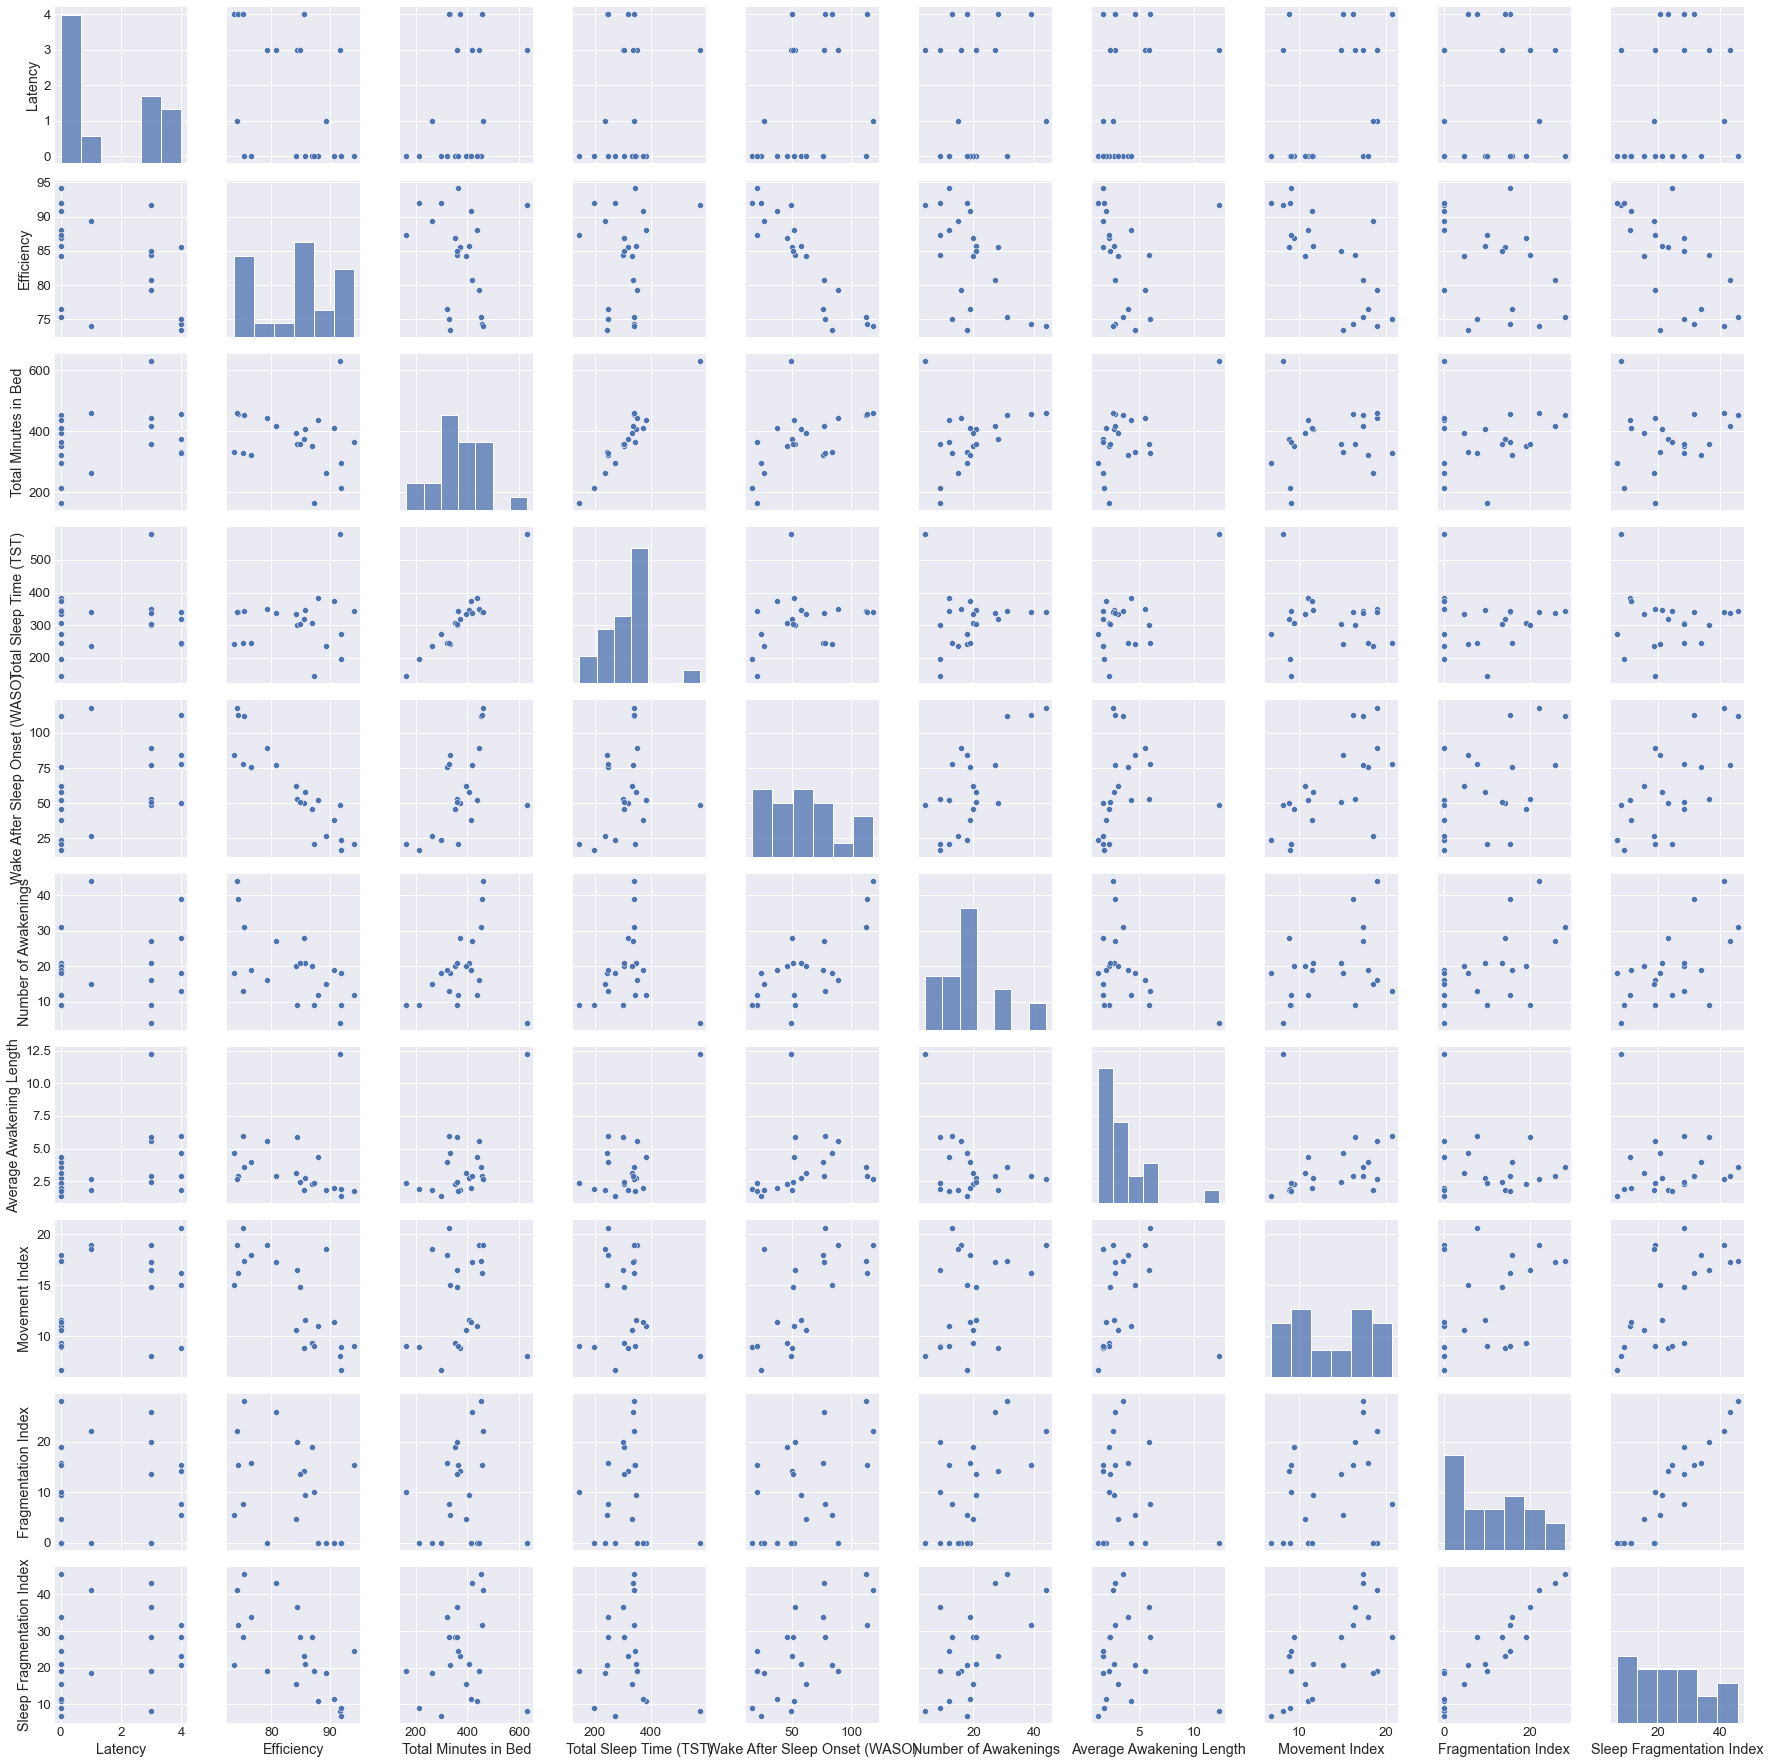

In [12]:
sns.pairplot(sleep_data_static['sleep'].iloc[:,6:]);


There are several relationships:   
- 'Wake After Sleep Onset' and 'Efficiency' (inverse linear)
- 'Wake After Sleep Onset' and 'Sleep Fragmentation Index' (linear)
- ?'Wake After Sleep Onset' and 'Total Minutes in Bed' (non linear)
- 'Number of Awakenings' and 'Efficiency' (inverse linear)
- ?'Number of Awakenings' and 'Total Minutes in Bed' (non linear)
- 'Movement Index' and 'Average Awakening Length' (linear)


#### 'questionnaire' dataset

In [17]:
print(f"Shape: {sleep_data_static['questionnaire'].shape}")
display(sleep_data_static['questionnaire'].head(5))
sleep_data_static['questionnaire'].describe()

Shape: (22, 19)


,MEQ,STAI1,STAI2,Pittsburgh,Daily_stress,BISBAS_bis,BISBAS_reward,BISBAS_drive,BISBAS_fun,panas_pos_10,panas_pos_14,panas_pos_18,panas_pos_22,panas_pos_9+1,panas_neg_10,panas_neg_14,panas_neg_18,panas_neg_22,panas_neg_9+1
User,,,,,,,,,,,,,,,,,,,
user_11,38.0,36.0,43.0,7.0,17.0,23.0,19.0,11.0,13.0,23.0,16.0,22.0,30.0,13.0,15.0,15.0,11.0,13.0,14.0
user_7,46.0,33.0,0.0,7.0,69.0,19.0,19.0,12.0,6.0,22.0,13.0,13.0,11.0,13.0,11.0,13.0,16.0,14.0,13.0
user_2,52.0,24.0,39.0,7.0,26.0,26.0,21.0,12.0,6.0,37.0,32.0,24.0,27.0,33.0,11.0,10.0,16.0,17.0,18.0
user_16,45.0,29.0,41.0,5.0,32.0,26.0,19.0,11.0,13.0,29.0,23.0,29.0,24.0,25.0,12.0,13.0,18.0,15.0,17.0
user_13,48.0,30.0,43.0,4.0,27.0,22.0,19.0,14.0,12.0,22.0,NaN,26.0,14.0,23.0,13.0,NaN,11.0,13.0,12.0


,MEQ,STAI1,STAI2,Pittsburgh,Daily_stress,BISBAS_bis,BISBAS_reward,BISBAS_drive,BISBAS_fun,panas_pos_10,panas_pos_14,panas_pos_18,panas_pos_22,panas_pos_9+1,panas_neg_10,panas_neg_14,panas_neg_18,panas_neg_22,panas_neg_9+1
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,21.000000,22.000000,22.000000,22.000000,22.000000,21.000000,22.000000,22.000000,22.000000
mean,50.318182,35.636364,39.500000,5.318182,32.181818,22.318182,19.545455,12.227273,10.818182,27.272727,23.761905,25.272727,20.500000,23.409091,14.181818,14.476190,15.318182,15.000000,13.090909
std,7.026388,8.329783,10.285218,1.985336,16.296761,2.456989,2.649839,2.068628,3.389569,4.692261,6.114775,6.400758,5.133921,6.028970,4.666357,4.534524,4.213203,3.988077,2.348436
min,38.000000,24.000000,0.000000,2.000000,10.000000,19.000000,14.000000,8.000000,5.000000,21.000000,13.000000,12.000000,11.000000,13.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,45.250000,29.250000,39.000000,4.000000,22.250000,20.000000,18.000000,11.000000,8.250000,23.250000,20.000000,21.250000,17.250000,20.500000,11.000000,12.000000,11.500000,13.000000,11.250000
50%,49.500000,33.500000,42.000000,5.000000,30.500000,22.000000,19.000000,12.000000,11.000000,28.000000,24.000000,25.500000,20.500000,24.000000,13.000000,13.000000,14.500000,14.500000,13.000000
75%,55.000000,40.500000,44.750000,7.000000,40.250000,24.000000,21.000000,14.000000,13.750000,29.750000,27.000000,30.000000,23.750000,25.750000,14.750000,15.000000,17.750000,15.750000,14.750000
max,64.000000,54.000000,49.000000,9.000000,74.000000,26.000000,25.000000,16.000000,16.000000,37.000000,34.000000,36.000000,30.000000,35.000000,26.000000,29.000000,24.000000,27.000000,18.000000


TBD

#### 'user_info' dataset

In [6]:
print(f"Shape: {sleep_data_static['user_info'].shape}")
display(sleep_data_static['user_info'].head(5))
sleep_data_static['user_info'].value_counts("Gender")

Shape: (22, 4)


,Gender,Weight,Height,Age
User,,,,
user_11,M,115,186,27
user_7,M,65,183,25
user_2,M,95,183,27
user_16,M,67,176,27
user_13,M,74,180,25


Gender
M    22
dtype: int64

In [7]:
sleep_data_static['user_info'].describe()

,Weight,Height,Age
count,22.000000,22.000000,22.000000
mean,75.045455,179.909091,26.045455
std,12.789420,8.216760,7.121244
min,60.000000,169.000000,0.000000
25%,67.000000,175.000000,25.000000
50%,70.000000,180.000000,27.000000
75%,80.000000,183.000000,27.750000
max,115.000000,205.000000,40.000000


The experiment includes only men with similar age so let's exclude user_info dataset from the future analysis.

### Dynamic data

#### 'activity' dataset

In [15]:
sleep_data_dynamic['activity']['user_1'].sort_values(['Day', 'Start']).head()

,Activity,Start,End,Day
0,2,10:00,10:22,1
1,9,10:37,10:40,1
2,10,10:40,10:45,1
3,6,10:55,11:00,1
4,2,11:00,11:20,1


Some of the activities during the day can lead to worse sleep, e.g. alchohol assumption or caffeinated drink consumption, or better sleep, e.g. sport excercises. This hypothesis can be used during EDA.

#### 'RR' dataset

In [13]:
sleep_data_dynamic['rr']['user_1'].head()

,ibi_s,day,time
1,0.258,1,10:10:17
2,0.319,1,10:10:18
3,0.266,1,10:10:18
4,0.401,1,10:10:18
5,1.089,1,10:10:19


#### 'actigraph' dataset

In [14]:
sleep_data_dynamic['actigraph']['user_1'].head()

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time
82,0,0,0,0,68.0,0,1,0,0,0.00,1,10:10:22
83,11,4,7,1,68.0,0,1,0,0,13.64,1,10:10:23
84,0,21,10,0,68.0,0,0,1,0,23.26,1,10:10:24
85,0,1,24,0,68.0,0,0,1,0,24.02,1,10:10:25
86,34,14,63,1,154.0,0,1,0,0,72.95,1,10:10:26


## Exploratory data analysis  

### 'sleep'  and 'saliva' datasets

Let's try to get some insights from 'sleep' and 'saliva' datasets.

**Hypotheses:**

- The lower 'Cortisol_before' and the higher 'Melatonin_before', the higher sleep 'Efficiency'
- The higher 'Melatonin_before', the lower 'Number of Awakenings'

- ?The higher 'Melatonin_before', the earlier the bedtime (the combination of 'In Bed Date' and 'In Bed Time')
- ?'Fragmentation Index'


TBD:
- go to sleep time, sleep length, evening melatonin, evening cortisol vs morning melatonin/cortisol/sleep efficiency
- daily activity type (Tv or sport) vs sleep efficiency
- 'Wake After Sleep Onset' and 'Efficiency' (inverse linear)
- 'Wake After Sleep Onset' and 'Sleep Fragmentation Index' (linear)
- ?'Wake After Sleep Onset' and 'Total Minutes in Bed' (non linear)
- 'Number of Awakenings' and 'Efficiency' (inverse linear)
- ?'Number of Awakenings' and 'Total Minutes in Bed' (non linear)
- 'Movement Index' and 'Average Awakening Length' (linear)

In [31]:
wake_after_sleep_onset = sleep_data_static['sleep']['Wake After Sleep Onset (WASO)'].astype('float64')
efficiency = sleep_data_static['sleep']['Efficiency'].astype('float64')

In [34]:
wake_after_sleep_onset.corr(efficiency)

-0.9109594069377525

## Build a model

In [23]:

numeric_features = ['Activity (steps)', 'sleep_time_in_hr', 'sleep_start_time']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = ['activity_level', 'sleep_time_adequacy', 'sleep_start_time_type']
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
    ])

In [24]:
lr_param_grid = {'C': np.arange(0.0, 1.1, 0.1), # [0.01, 0.1, 1.0, 10.0], # 
                 'penalty': ['l1', 'l2']}

n_splits = 5
grid_search = GridSearchCV(
    LinearRegression(),
    param_grid=lr_param_grid,
#     cv=KFold( shuffle=True, random_state=42),
    cv=5,
    scoring='accuracy'
)

pipeline  = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search', grid_search)
])
print('Cross val score: {:f}'.format(cross_val_score(pipeline, data[numeric_features], y, scoring='accuracy', cv=5).mean()))


NameError: name 'data' is not defined

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data[numeric_features], y, test_size=0.3, shuffle=True, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.4, shuffle=True, random_state=4)


In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_train = linreg.predict(X_train)
y_pred_val = linreg.predict(X_val)

print(f'Train MSE {mean_squared_error(y_train, y_pred_train)}, test MSE {mean_squared_error(y_val, y_pred_val)}')


In [ ]:
# todo: 
# add RandomForest model, 
# fix pipeline, 
# sleep_quality is not gaussian, 

# better crossvalidation https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression and
# https://towardsdatascience.com/understanding-8-types-of-cross-validation-80c935a4976d

# ridge regularization
lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=5)
print(scores)

folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lr, X_train, y_train, scoring='r2', cv=folds)
print(scores)

Possible improvements: 
- add unit tests
- use keras
- use one of AutoML frameworks
- configure pipelines (dvc)
- use 3d party tools for data visualization and preliminary analysis (Dataiku)

Some papers on actigraph data analysis  
https://paperswithcode.com/search?q_meta=&q_type=&q=actigraph
https://mne.tools/stable/auto_tutorials/clinical/60_sleep.html
https://github.com/miracl1e6/credit-scoring/blob/main/credit-scoring-eda-ml.ipynb
